In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Define paths for the model and data of interest

In [2]:
# Define the paths to the peak BEDs and profile BigWigs
base_path = "/users/amtseng/att_priors/data/interim/ENCODE/profile/OLD/SPI1"

peaks_bed = os.path.join(base_path, "SPI1_ENCSR000BGW_K562_all_peakints.bed.gz")

prof_bigwigs = [
    (os.path.join(base_path, e_1), os.path.join(base_path, e_2))
    for e_1, e_2 in [
        ("SPI1_ENCSR000BGQ_GM12878_neg.bw",
         "SPI1_ENCSR000BGQ_GM12878_pos.bw"),
        ("SPI1_ENCSR000BGW_K562_neg.bw",
         "SPI1_ENCSR000BGW_K562_pos.bw"),
        ("SPI1_ENCSR000BIJ_GM12891_neg.bw",
         "SPI1_ENCSR000BIJ_GM12891_pos.bw"),
        ("SPI1_ENCSR000BUW_HL-60_neg.bw",
         "SPI1_ENCSR000BUW_HL-60_pos.bw"),

        ("control_ENCSR000BGH_GM12878_neg.bw",
         "control_ENCSR000BGH_GM12878_pos.bw"),
        ("control_ENCSR000BGG_K562_neg.bw",
         "control_ENCSR000BGG_K562_pos.bw"),
        ("control_ENCSR000BIH_GM12891_neg.bw",
         "control_ENCSR000BIH_GM12891_pos.bw"),
        ("control_ENCSR000BVU_HL-60_neg.bw",
         "control_ENCSR000BVU_HL-60_pos.bw")
    ]
]
num_tasks = int(len(prof_bigwigs) / 2)
# Path to saved model
model_path = "/users/amtseng/att_priors/models/trained_profile_models/SPI1_TEST/20/model_ckpt_epoch_2.pt"

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [3]:
# Define some constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000

In [4]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=1)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)

In [5]:
# Maps single coordinate to input sequence and profiles for the network
def coord_to_network_inputs(chrom, start, end):
    input_seq = coords_to_seq([(chrom, start, end)])
    profs = coords_to_profs([(chrom, start, end)])
    return input_seq, profs

In [6]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [7]:
# Import the model
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
torch.set_grad_enabled(False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 

In [40]:
def predict_coord(chrom, start, end):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned profiles are in terms of raw counts, and the returned counts are
    also raw. Returned values are all NumPy arrays.
    """
    input_seq, profiles = coord_to_network_inputs(chrom, start, end)
    
    input_seq = model_util.place_tensor(torch.tensor(input_seq)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    # Make channels come first in input
    input_seq = torch.transpose(input_seq, 1, 2)

    # Run through the model
    logit_pred_profs, log_pred_counts = model(input_seq, cont_profs)
    
    # Convert logit profile predictions to probabilities
    # pred_prof_probs = torch.nn.functional.softmax(logit_pred_profs)
    sig_pred_profs = torch.nn.Sigmoid()(logit_pred_profs)
    sig_sums = torch.sum(sig_pred_profs, dim=-1).unsqueeze(-1)
    pred_prof_probs = torch.div(sig_pred_profs, sig_sums)
    
    # Convert log counts to counts
    pred_counts = torch.exp(log_pred_counts) - 1
    
    # Convert profile probabilities to profile counts
    pred_profs = torch.mul(pred_prof_probs, pred_counts.unsqueeze(-1).repeat(1, 1, 1, pred_prof_probs.size(-1)))
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=3)
    
    return pred_profs.cpu().numpy()[0], pred_counts.cpu().numpy()[0], true_profs.cpu().numpy()[0], true_counts.cpu().numpy()[0]

In [9]:
def plot_profiles(pred_profs, true_profs, normalize=True, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x 2 x O NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[2]
    if normalize:
        pred_profs = pred_profs / np.expand_dims(np.max(pred_profs, axis=2), axis=2)
        true_profs = true_profs / np.expand_dims(np.max(true_profs, axis=2), axis=2)
    fig, ax = plt.subplots(num_tasks, figsize=(15, 20))
    for i in range(num_tasks):
        ax[i].plot(pred_profs[i][0], color="royalblue")
        ax[i].plot(-pred_profs[i][1], color="darkorange")
        ax[i].plot(true_profs[i][0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i][1], color="darkorange", alpha=0.5)
    if title:
        fig.suptitle(title)

### View predictions

In [10]:
# Sample some positive coordinates
pos_coords_table.sample(10)

,0,1,2
9484,chr14,50551581,50552581
18724,chr20,42050886,42051886
24095,chr5,109573441,109574441
12226,chr16,86575447,86576447
12737,chr17,31094425,31095425
13464,chr17,64479294,64480294
9490,chr14,51239731,51240731
11296,chr16,11611951,11612951
5370,chr10,124760294,124761294
20076,chr22,39319261,39320261


In [11]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

array([['chr6', 100547732, 100549078],
       ['chr6', 134623975, 134625321],
       ['chrX', 79288770, 79290116],
       ['chr2', 215474550, 215475896],
       ['chr6', 49620340, 49621686],
       ['chr13', 52904964, 52906310],
       ['chr7', 100927166, 100928512],
       ['chr9', 103093080, 103094426],
       ['chr1', 138879843, 138881189],
       ['chr6', 106702916, 106704262]], dtype=object)

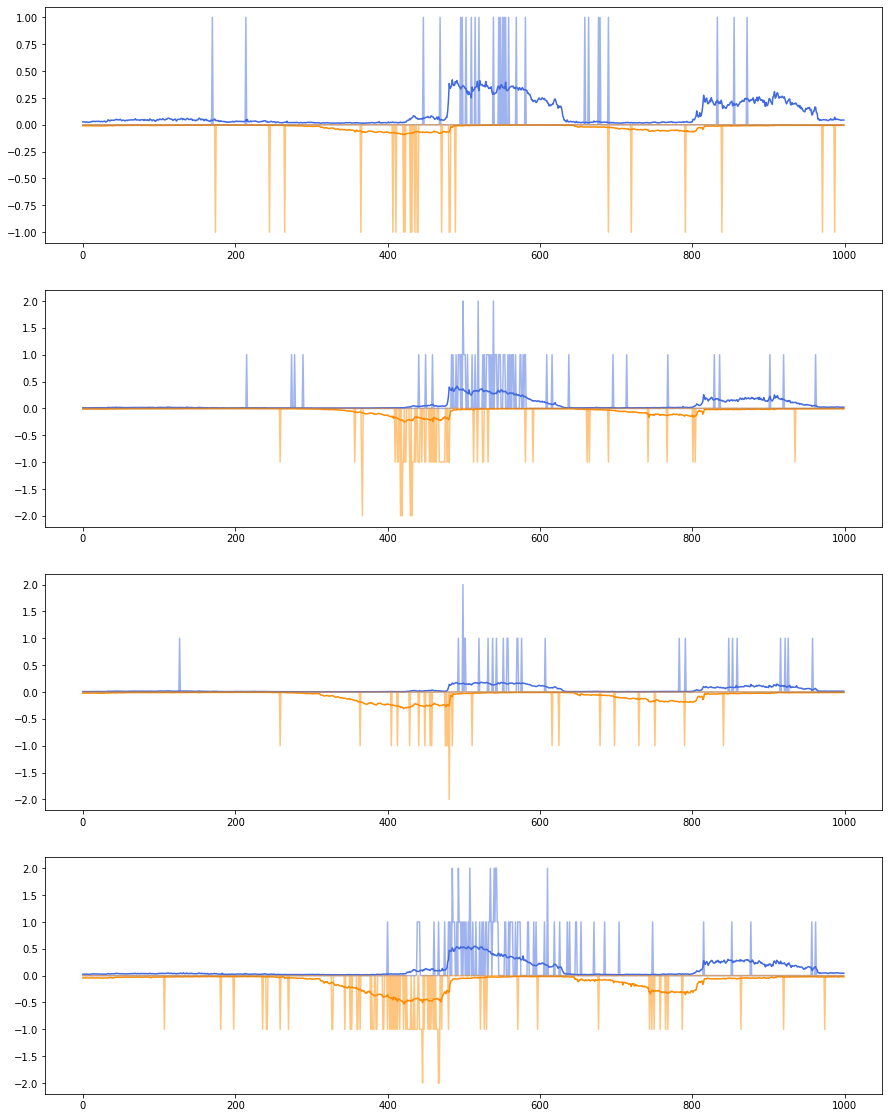

In [27]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr5", 935336, 936336)
plot_profiles(pred_profs, true_profs, normalize=False)

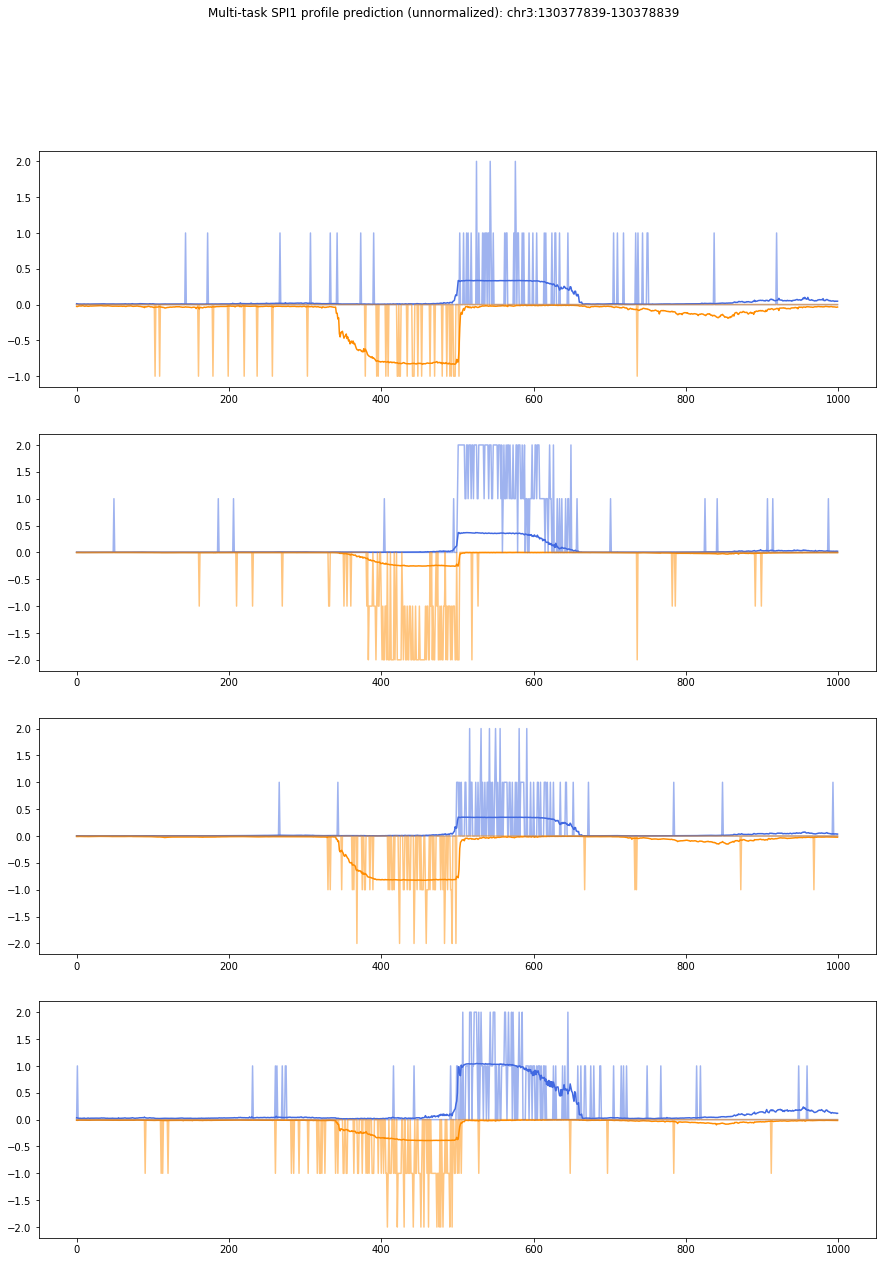

In [23]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr3", 130377839, 130378839)
plot_profiles(pred_profs, true_profs, normalize=False, title="Multi-task SPI1 profile prediction (unnormalized): chr3:130377839-130378839")

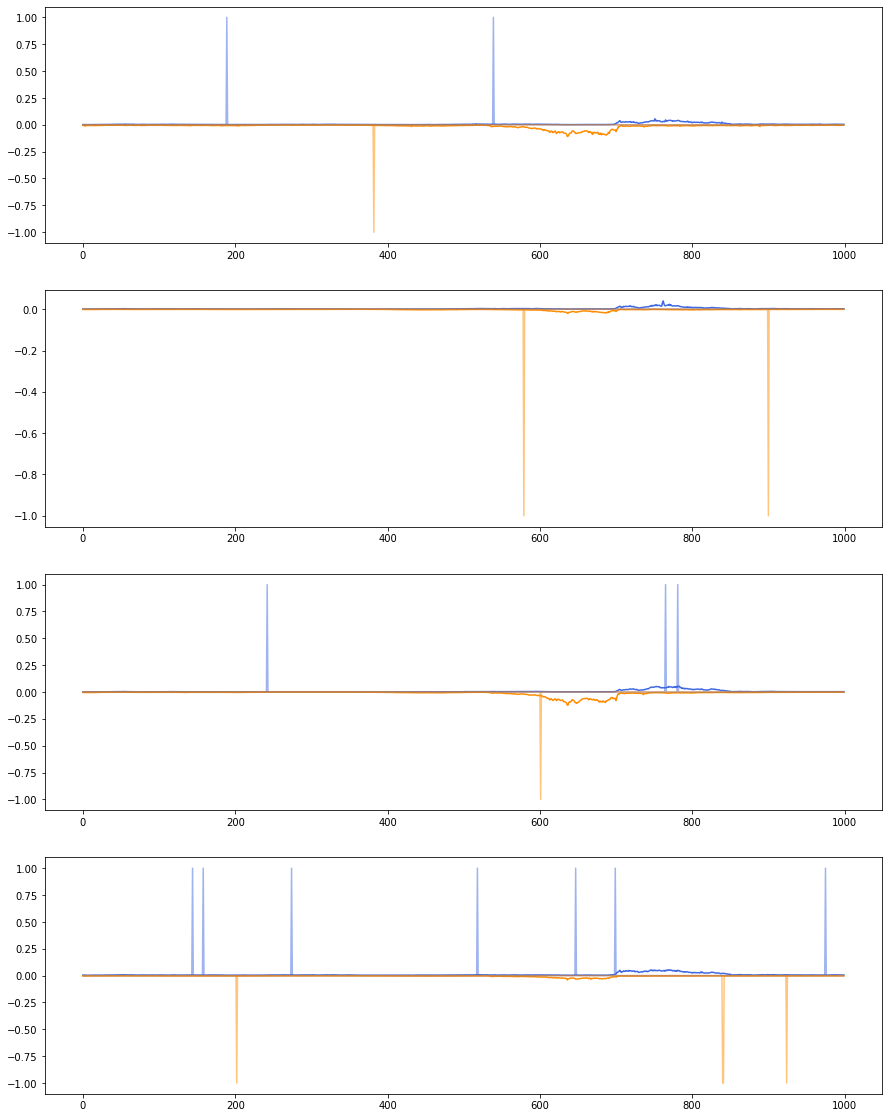

In [21]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr2", 1000000, 1001000)
plot_profiles(pred_profs, true_profs, normalize=False)

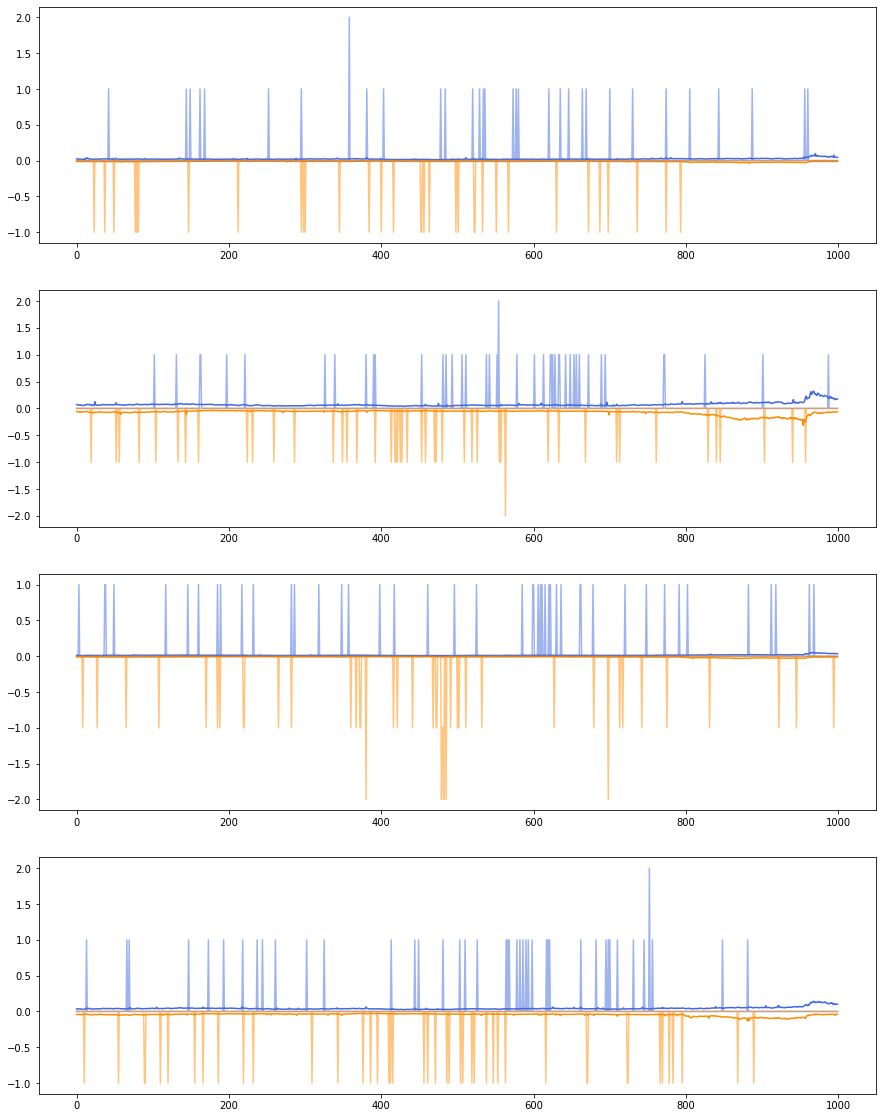

In [32]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr7", 139359227, 139360227)
plot_profiles(pred_profs, true_profs, normalize=False)

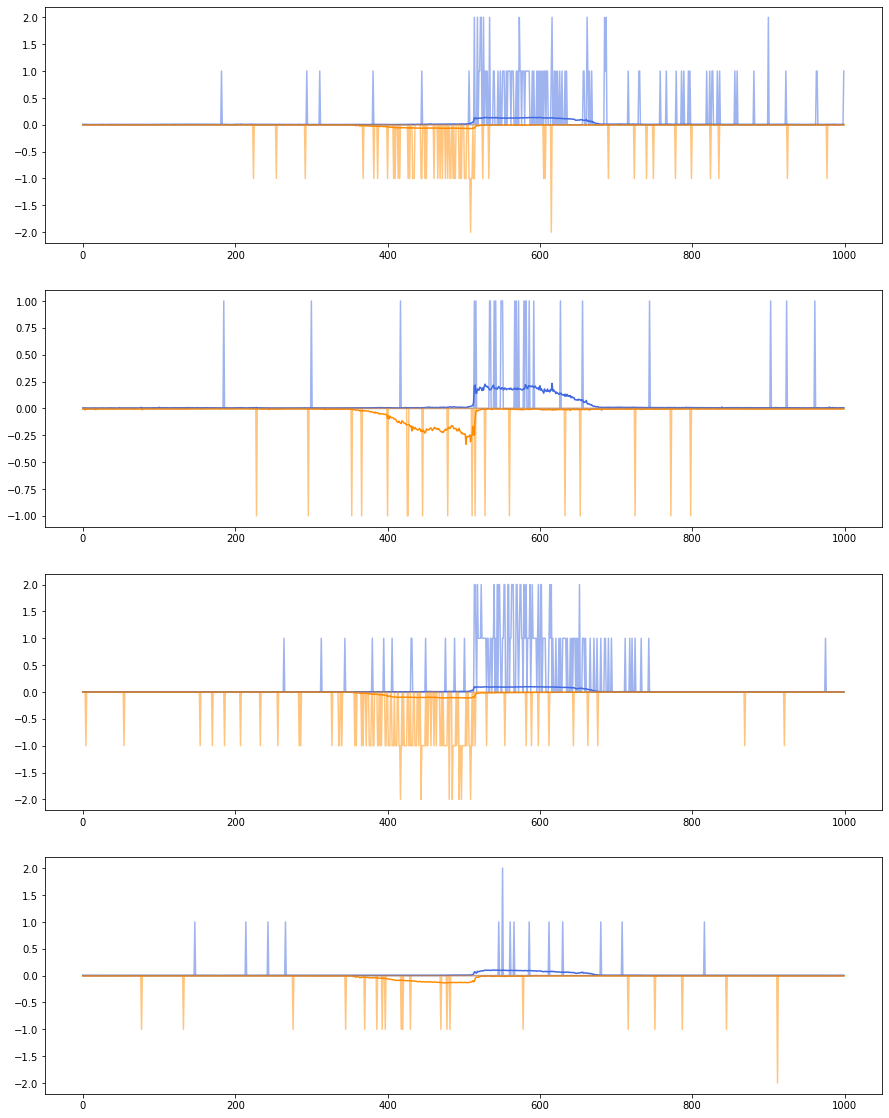

In [44]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr6", 150184612, 150185612)
plot_profiles(pred_profs, true_profs, normalize=False)

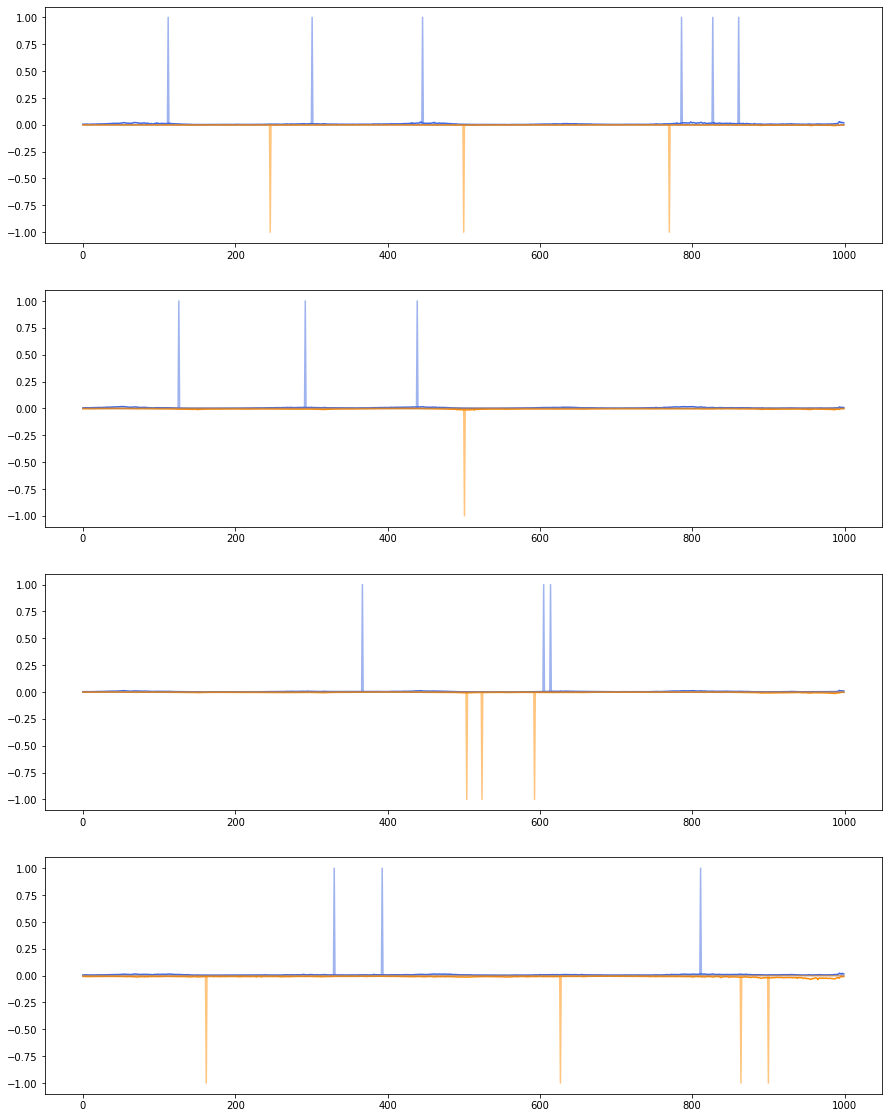

In [43]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr2", 32404187, 32405187)
plot_profiles(pred_profs, true_profs, normalize=False)

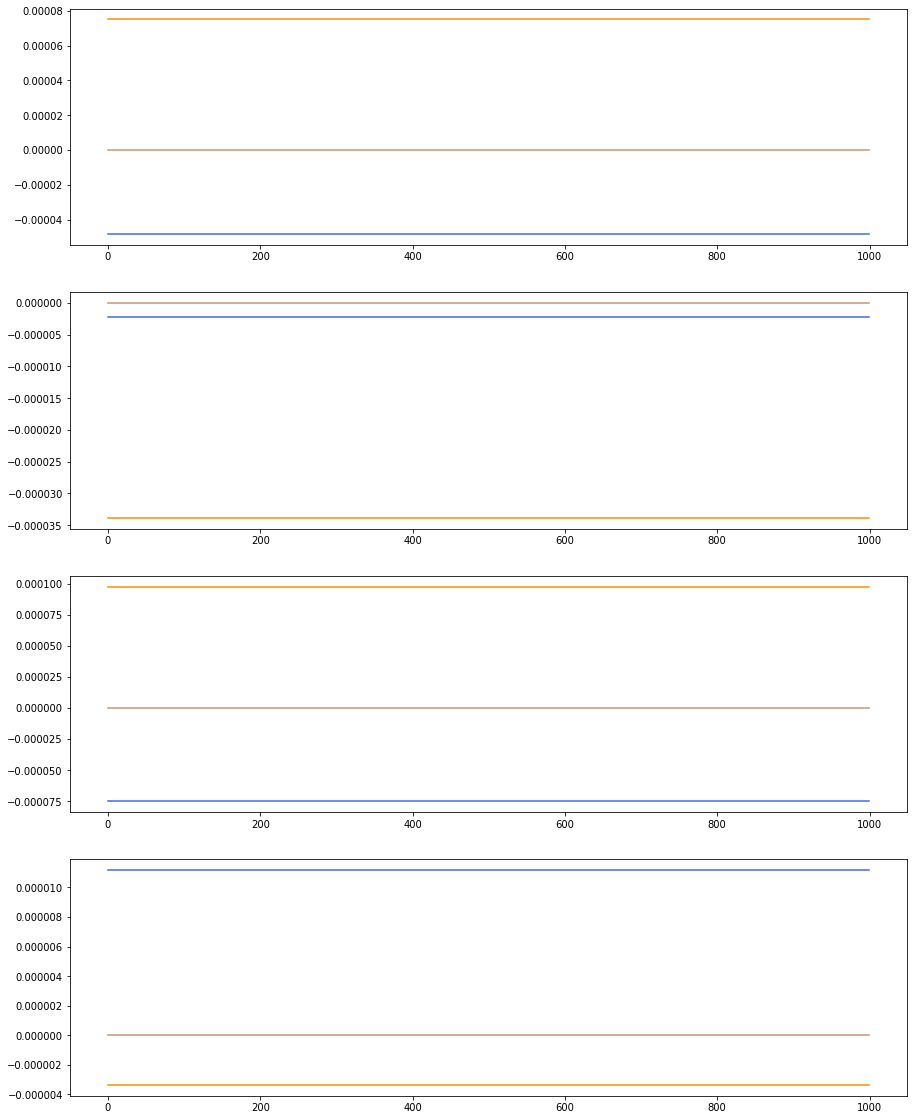

In [42]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr9", 60457357, 60458357)
plot_profiles(pred_profs, true_profs, normalize=False)